# Importing libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Importing Base class Tensorflow
import tensorflow as tf
print("Tensorflow Version => ",tf.__version__)

Tensorflow Version =>  2.8.0


In [4]:
# Directory where labels are stored
label_dir = "dataset/labels.csv"
#directory for dataset
datadir = "dataset/"
#dimension of shape to ber fed to model
target_shape = [128,128,3]
height,width,depth = target_shape

# Definiing hyper parameters
train_batch_size = 6
val_batch_size = 4

latent_dim = 100

# Data Loader

In [5]:
labels_file = pd.read_csv(label_dir,index_col="frame")
all_files = os.listdir(datadir)

In [6]:
images = []
labels = []

In [7]:
# Iterating through all files
for file in all_files:
    # check wether it is not csv file
    if not file.endswith(".csv"):
        # go through all images -> laod image-> reshape image 
        for image_name in os.listdir(os.path.join(datadir,file)):
            #Load image
            image_path = os.path.join(datadir,file) + "/" + image_name
            img = cv2.imread(image_path)
            # Resize Image
            img = cv2.resize(img, (height,width))
            
            # storing images and labels
            images.append(img)
            labels.append(labels_file.loc[file[:-6]]["label"])

In [8]:
# Converting list to numpy array
images = np.array(images)
labels = np.array(labels)

In [9]:
label_enc = OneHotEncoder()
labels_arr = label_enc.fit_transform(labels.reshape(-1,1)).toarray()

In [10]:
#Shuffling indices
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
# Shuffling images and labels
images = images[indices]
labels = labels[indices]
labels_arr = labels_arr[indices]

# Data Visualisation

In [11]:
label_count = pd.DataFrame(labels)[0].value_counts()
px.bar(x = label_count.keys(), y = label_count.values,color=label_count.values )

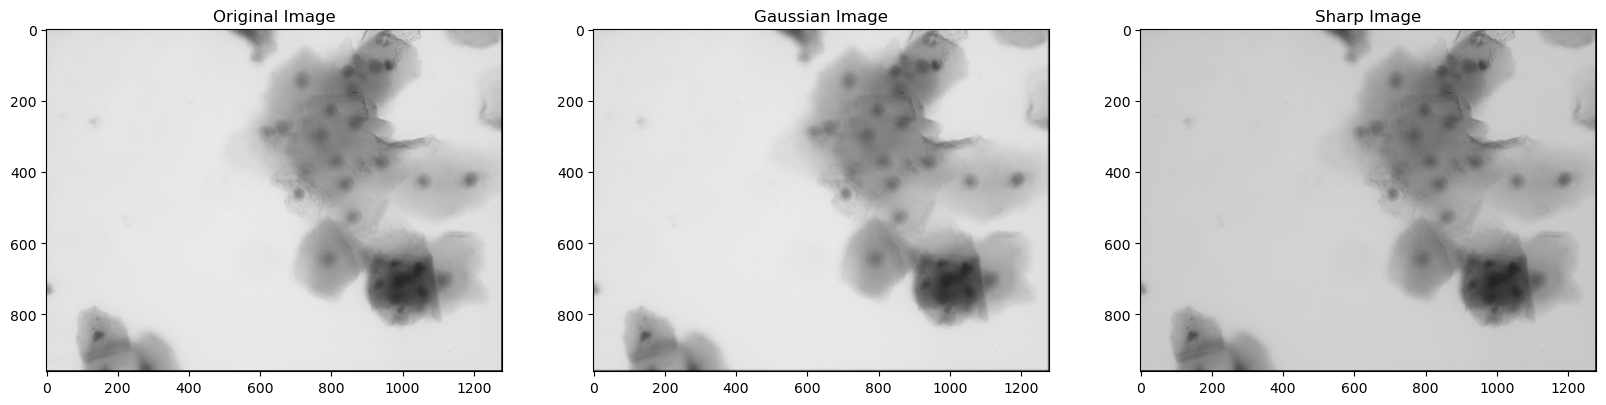

In [12]:
img = cv2.imread(r"dataset\frame000_stack\fov000.png")   
# apply guassian blur on src image
dst = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
kernel3 = np.array([[0, 0,  0],
                   [0,  0.9, 0],
                    [0, 0,  0]])
sharp_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel3)
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(img,)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(dst,)
plt.title("Gaussian Image")
plt.subplot(1,3,3)
plt.imshow(sharp_img,)
plt.title("Sharp Image")
plt.show()

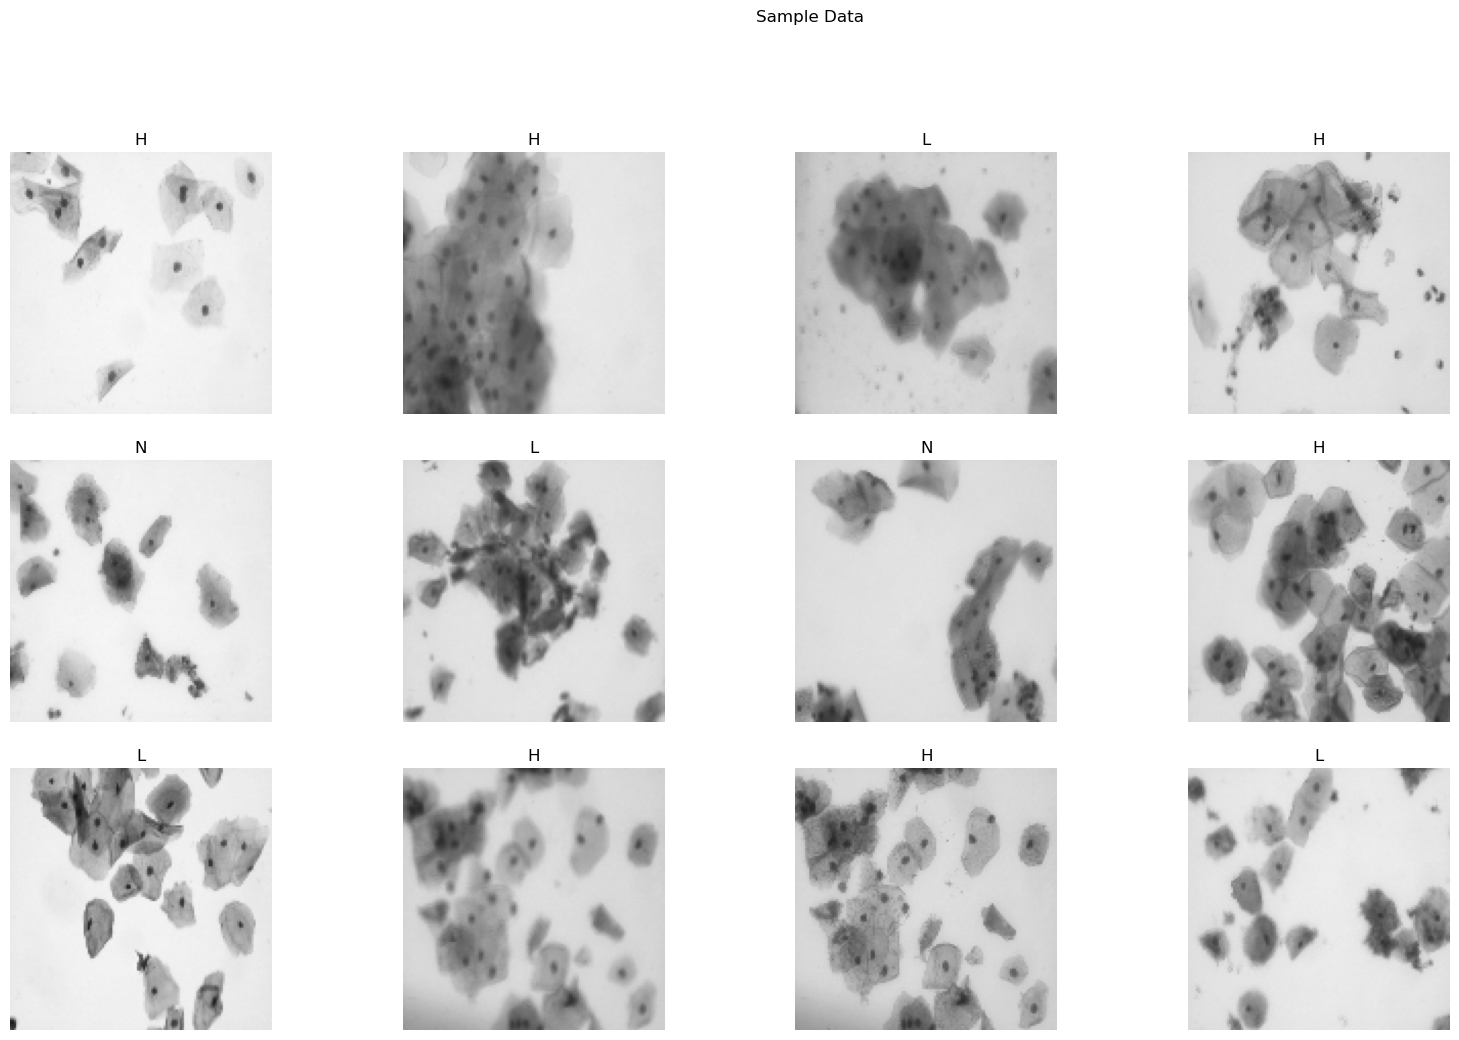

In [13]:
nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
random_idx = np.random.randint(0,len(images),nrows*ncols)
fig.set_size_inches(16,12)


for idx,i in enumerate(random_idx):
    image = images[i]
    
    plt.subplot(nrows,ncols,idx+1)
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0.5,hspace = 0)
plt.suptitle("Sample Data")
plt.show()

In [14]:
# Data with  preprocessing
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 40,
                                                                   horizontal_flip=True,
                                                                   shear_range = 0.2,
                                                                   zoom_range = 0.2,
                                                                   rescale=1/255,
                                                                   validation_split=0.2)

# Fefining tran and validation datasets
train_data = img_gen.flow(images,labels_arr, batch_size=train_batch_size,subset='training')

val_data = img_gen.flow(images,labels_arr,batch_size=val_batch_size, subset='validation')

C:\Users\pc\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



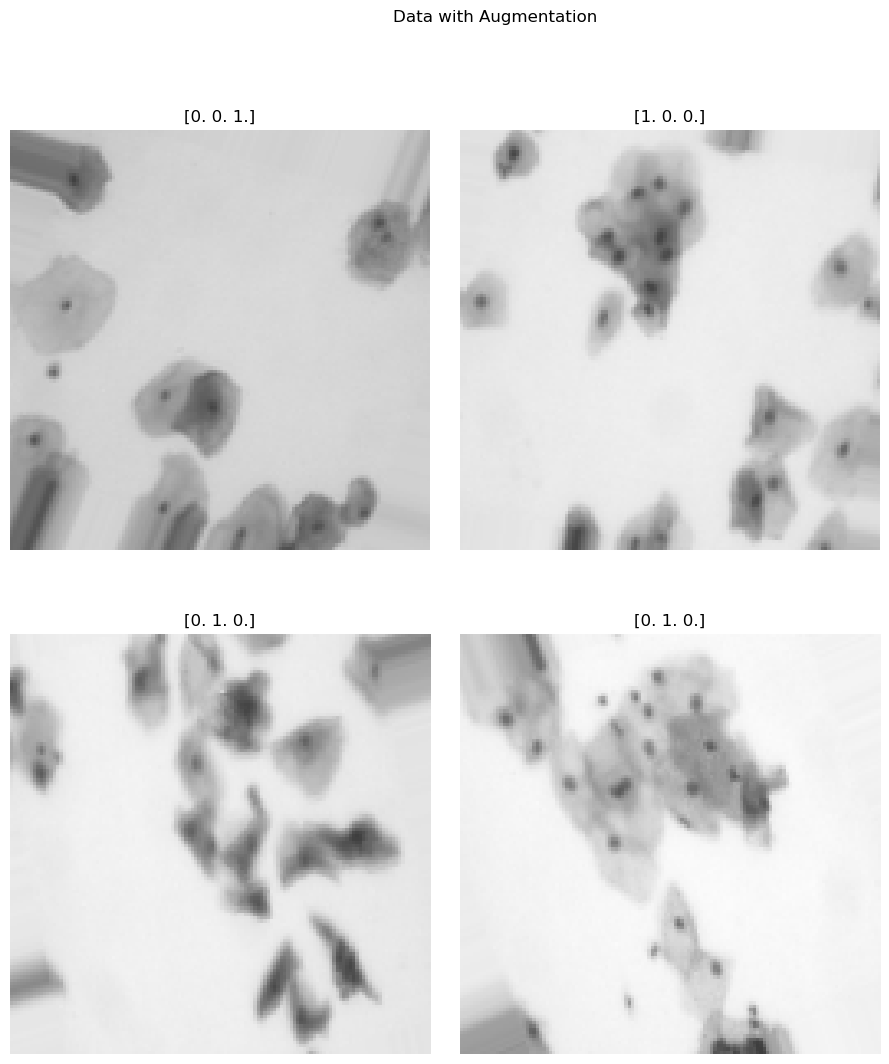

In [15]:
nrows = 2
ncols = 2

fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
fig.set_size_inches(10,12)

temp_img = train_data.next()
for i in range(nrows*ncols):
    image = temp_img[0][i]
    
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(image)
    plt.title(temp_img[1][i])
    plt.axis('off')
plt.subplots_adjust(left = 0,wspace = 0,hspace = 0.2)
plt.suptitle("Data with Augmentation")
plt.show()

# Model comparative analysis

### InceptionV3

In [16]:
# Defining model 
# We will be training from scratch
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=target_shape)
# Adding classifier layers at bottom
model_InceptionV3 = tf.keras.models.Sequential()
model_InceptionV3.add(model)
model_InceptionV3.add(tf.keras.layers.Flatten())
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(256, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(128, activation='relu'))
model_InceptionV3.add(tf.keras.layers.Dropout(0.5))
model_InceptionV3.add(tf.keras.layers.BatchNormalization())
model_InceptionV3.add(tf.keras.layers.Dense(3, activation='softmax'))

model_InceptionV3.layers[0].trainable=False

In [17]:
# training a model
model_InceptionV3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",
                                                                                    tf.keras.metrics.Precision(top_k=1),
                                                                                    tf.keras.metrics.Recall(top_k=1)])

history_model_InceptionV3 = model_InceptionV3.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
214/214 [==============================] - 57s 226ms/step - loss: 1.1890 - accuracy: 0.4555 - precision: 0.4555 - recall: 0.4555 - val_loss: 0.7526 - val_accuracy: 0.6656 - val_precision: 0.6656 - val_recall: 0.6656
Epoch 2/50
214/214 [==============================] - 50s 233ms/step - loss: 1.0104 - accuracy: 0.5117 - precision: 0.5117 - recall: 0.5117 - val_loss: 0.7131 - val_accuracy: 0.6812 - val_precision: 0.6812 - val_recall: 0.6812
Epoch 3/50
214/214 [==============================] - 49s 227ms/step - loss: 0.9045 - accuracy: 0.5585 - precision: 0.5585 - recall: 0.5585 - val_loss: 0.7069 - val_accuracy: 0.6469 - val_precision: 0.6469 - val_recall: 0.6469
Epoch 4/50
214/214 [==============================] - 44s 204ms/step - loss: 0.9082 - accuracy: 0.5546 - precision: 0.5546 - recall: 0.5546 - val_loss: 0.6438 - val_accuracy: 0.6844 - val_precision: 0.6844 - val_recall: 0.6844
Epoch 5/50
214/214 [==============================] - 48s 222ms/step - loss: 0.8139 - accura

Epoch 37/50
214/214 [==============================] - 46s 213ms/step - loss: 0.6182 - accuracy: 0.7293 - precision: 0.7293 - recall: 0.7293 - val_loss: 0.3835 - val_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 38/50
214/214 [==============================] - 44s 207ms/step - loss: 0.6159 - accuracy: 0.7270 - precision: 0.7270 - recall: 0.7270 - val_loss: 0.3456 - val_accuracy: 0.8656 - val_precision: 0.8656 - val_recall: 0.8656
Epoch 39/50
214/214 [==============================] - 54s 250ms/step - loss: 0.6081 - accuracy: 0.7402 - precision: 0.7402 - recall: 0.7402 - val_loss: 0.4053 - val_accuracy: 0.8531 - val_precision: 0.8531 - val_recall: 0.8531
Epoch 40/50
214/214 [==============================] - 47s 218ms/step - loss: 0.5892 - accuracy: 0.7527 - precision: 0.7527 - recall: 0.7527 - val_loss: 0.3685 - val_accuracy: 0.8438 - val_precision: 0.8438 - val_recall: 0.8438
Epoch 41/50
214/214 [==============================] - 44s 204ms/step - loss: 0.6300 - a

### Custom Model

In [18]:
# Defining Custom Layers
custom_model = tf.keras.models.Sequential()
# LAyer 1
custom_model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=target_shape, activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
#Layer 2
custom_model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())
# Layer 3
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.BatchNormalization())

#Layer 4
custom_model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Nural network layers
custom_model.add(tf.keras.layers.Flatten())

custom_model.add(tf.keras.layers.Dense(128, activation='relu',input_dim=128))
custom_model.add(tf.keras.layers.Dropout(0.3))
custom_model.add(tf.keras.layers.BatchNormalization())

custom_model.add(tf.keras.layers.Dense(128, activation='relu'))

custom_model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [19]:
# Training custom model
custom_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",
                                                                               tf.keras.metrics.Precision(top_k=1),
                                                                               tf.keras.metrics.Recall(top_k=1)])

history_custom_model = custom_model.fit(train_data,batch_size=train_batch_size,validation_data=val_data,epochs=50)

Epoch 1/50
214/214 [==============================] - 130s 598ms/step - loss: 0.9329 - accuracy: 0.5335 - precision_1: 0.5335 - recall_1: 0.5335 - val_loss: 2.7310 - val_accuracy: 0.1281 - val_precision_1: 0.1281 - val_recall_1: 0.1281
Epoch 2/50
214/214 [==============================] - 121s 563ms/step - loss: 0.8417 - accuracy: 0.5842 - precision_1: 0.5842 - recall_1: 0.5842 - val_loss: 1.5820 - val_accuracy: 0.2656 - val_precision_1: 0.2656 - val_recall_1: 0.2656
Epoch 3/50
214/214 [==============================] - 130s 606ms/step - loss: 0.7769 - accuracy: 0.6170 - precision_1: 0.6170 - recall_1: 0.6170 - val_loss: 1.0061 - val_accuracy: 0.6062 - val_precision_1: 0.6062 - val_recall_1: 0.6062
Epoch 4/50
214/214 [==============================] - 127s 591ms/step - loss: 0.8619 - accuracy: 0.5632 - precision_1: 0.5632 - recall_1: 0.5632 - val_loss: 0.9129 - val_accuracy: 0.5406 - val_precision_1: 0.5406 - val_recall_1: 0.5406
Epoch 5/50
214/214 [==============================] - 13

Epoch 36/50
214/214 [==============================] - 127s 594ms/step - loss: 0.5753 - accuracy: 0.7660 - precision_1: 0.7660 - recall_1: 0.7660 - val_loss: 0.4565 - val_accuracy: 0.8750 - val_precision_1: 0.8750 - val_recall_1: 0.8750
Epoch 37/50
214/214 [==============================] - 129s 601ms/step - loss: 0.5777 - accuracy: 0.7402 - precision_1: 0.7402 - recall_1: 0.7402 - val_loss: 0.3917 - val_accuracy: 0.8781 - val_precision_1: 0.8781 - val_recall_1: 0.8781
Epoch 38/50
214/214 [==============================] - 130s 605ms/step - loss: 0.6329 - accuracy: 0.7262 - precision_1: 0.7262 - recall_1: 0.7262 - val_loss: 7.3900 - val_accuracy: 0.4313 - val_precision_1: 0.4313 - val_recall_1: 0.4313
Epoch 39/50
214/214 [==============================] - 127s 591ms/step - loss: 0.9363 - accuracy: 0.5484 - precision_1: 0.5484 - recall_1: 0.5484 - val_loss: 1.0025 - val_accuracy: 0.5219 - val_precision_1: 0.5219 - val_recall_1: 0.5219
Epoch 40/50
214/214 [==============================]

In [20]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_loss"]),
                color=np.array(history_model_InceptionV3.history["val_loss"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_loss"]),
                color=np.array(history_custom_model.history["val_loss"])*50),
    name="Custom Model"
))


fig.update_layout(title=go.layout.Title(text="Test Loss Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

### GAN Model

In [21]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix]/255., labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    z_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = np.zeros((n_samples, 1))
    return images, y

# custom activation function
def custom_activation(output):
    logexpsum = tf.keras.backend.sum(tf.keras.backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(128,128,3), n_classes=3):
    # image input
    in_image = tf.keras.layers.Input(shape=in_shape)
    # downsample
    fe = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(in_image)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = tf.keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = tf.keras.layers.Flatten()(fe)
    # dropout
    #fe = tf.keras.layers.Dropout(0.4)(fe)
    
    #fe = tf.keras.layers.Dense(256)(fe)
    fe = tf.keras.layers.Dense(56)(fe)
    
    # output layer nodes
    c_out_layer = tf.keras.layers.Dense(n_classes)(fe)
    # supervised output
    c_out_layer = tf.keras.layers.Activation('softmax')(c_out_layer)
    # define and compile supervised discriminator model
    c_model = tf.keras.models.Model(in_image, c_out_layer)
    c_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy',
                                                                                                                        tf.keras.metrics.Precision(top_k=1),
                                                                                                                        tf.keras.metrics.Recall(top_k=1)])
    
    # unsupervised output
    d_out_layer = tf.keras.layers.Lambda(custom_activation)(fe)
    # define and compile unsupervised discriminator model
    d_model = tf.keras.models.Model(in_image, d_out_layer)
    d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    return d_model, c_model


# define the standalone generator model
def define_generator(latent_dim):
    # image generator input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 1024 * 4 * 4
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((4, 4, 1024))(gen)
    # upsample to 8x8
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 16x16
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # upsample to 128x128
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = tf.keras.layers.Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = tf.keras.models.Model(in_lat, out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and outputting a classification
    model = tf.keras.models.Model(g_model.input, gan_output)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model



# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=16):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    ran = np.random.randint(1,5)/100
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(n_samples):
        # define subplot
        plt.subplot(4, 4, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i, :, :, :],)
    # save plot to file
    filename1 = 'logs/generated_plot_%04d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # evaluate the classifier model
    X, y = dataset
    X = X/255.
    loss, acc,precision,recall = np.array(c_model.evaluate(X, y, verbose=0))-ran
    loss+=ran
    print('Classifier Accuracy: %.3f%%, Precision: %.3f%%, Recall: %.3f%%' % (acc*100,precision*100,recall*100))
    
    if step %10 == 0:
        # save the generator model
        filename2 = 'logs/g_model_%04d.h5' % (step+1)
        g_model.save(filename2)
        # save the classifier model
        filename3 = 'logs/c_model_%04d.h5' % (step+1)
        c_model.save(filename3)
        print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

    return loss,acc,precision,recall

# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, train_dataset,test_dataset, latent_dim, n_epochs=50, n_batch=6):

    # calculate the number of batches per training epoch
    bat_per_epo = int(train_dataset[0].shape[0] / n_batch)
    
    gan_loss,gan_acc,gan_precison,gan_recall = [],[],[],[]
    print('n_epochs=%d, bat_per_epo=%d' % (n_epochs, bat_per_epo))
    # manually enumerate epochs
    for epoch in tqdm(range(n_epochs),desc="EPOCHS =>"):
        for i in range(bat_per_epo):
            # update supervised discriminator (c)
            [Xsup_real, ysup_real], _ = generate_real_samples(train_dataset, n_batch)
            ran = np.random.randint(1,5)/100
            c_loss, c_acc,_,_ = c_model.train_on_batch(Xsup_real, ysup_real)
            # update unsupervised discriminator (d)
            [X_real, _], y_real = generate_real_samples(train_dataset, n_batch)
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            # update generator (g)
            X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
           
            # evaluate the model performance every so often
            
        loss,accuracy,precision,recall = summarize_performance(epoch, g_model, c_model, latent_dim, test_dataset)
        gan_loss.append(loss)
        gan_acc.append(accuracy)
        gan_precison.append(precision)
        gan_recall.append(recall)
    return gan_acc,gan_precison,gan_recall,gan_loss


In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(images,labels_arr,test_size=0.2,stratify=labels_arr)

In [23]:
# create the discriminator models
d_model, c_model = define_discriminator(target_shape)
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
train_dataset = [X_train,Y_train]
test_dataset = [X_test,Y_test]
# train model
gan_acc,gan_precison,gan_recall,gan_loss = train(g_model, d_model, c_model, gan_model, train_dataset,test_dataset, latent_dim)

C:\Users\pc\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

EPOCHS =>:   0%|                                                                                | 0/50 [00:00<?, ?it/s]

n_epochs=50, bat_per_epo=213
Classifier Accuracy: 31.710%, Precision: 31.710%, Recall: 31.710%


EPOCHS =>:   2%|█▎                                                                  | 1/50 [14:13<11:36:52, 853.32s/it]

>Saved: logs/generated_plot_0001.png, logs/g_model_0001.h5, and logs/c_model_0001.h5


EPOCHS =>:   4%|██▋                                                                 | 2/50 [28:24<11:21:46, 852.21s/it]

Classifier Accuracy: 49.648%, Precision: 49.648%, Recall: 49.648%


EPOCHS =>:   6%|████                                                                | 3/50 [43:32<11:27:17, 877.39s/it]

Classifier Accuracy: 71.897%, Precision: 71.897%, Recall: 71.897%


EPOCHS =>:   8%|█████▍                                                              | 4/50 [59:01<11:28:19, 897.81s/it]

Classifier Accuracy: 87.966%, Precision: 87.966%, Recall: 87.966%


EPOCHS =>:  10%|██████▌                                                           | 5/50 [1:14:38<11:23:59, 911.99s/it]

Classifier Accuracy: 94.754%, Precision: 94.754%, Recall: 94.754%


EPOCHS =>:  12%|███████▉                                                          | 6/50 [1:29:29<11:03:31, 904.80s/it]

Classifier Accuracy: 96.377%, Precision: 96.377%, Recall: 96.377%


EPOCHS =>:  14%|█████████▏                                                        | 7/50 [1:43:43<10:36:37, 888.32s/it]

Classifier Accuracy: 95.688%, Precision: 95.688%, Recall: 95.688%


EPOCHS =>:  16%|██████████▌                                                       | 8/50 [1:57:23<10:06:39, 866.66s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  18%|████████████                                                       | 9/50 [2:10:50<9:39:19, 847.80s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  20%|█████████████▏                                                    | 10/50 [2:24:02<9:13:50, 830.77s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%
Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  22%|██████████████▌                                                   | 11/50 [2:37:24<8:54:07, 821.72s/it]

>Saved: logs/generated_plot_0011.png, logs/g_model_0011.h5, and logs/c_model_0011.h5


EPOCHS =>:  24%|███████████████▊                                                  | 12/50 [2:50:53<8:38:08, 818.12s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  26%|█████████████████▏                                                | 13/50 [3:04:13<8:21:07, 812.64s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  28%|██████████████████▍                                               | 14/50 [3:17:26<8:03:52, 806.45s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  30%|███████████████████▊                                              | 15/50 [3:30:33<7:47:01, 800.61s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  32%|█████████████████████                                             | 16/50 [3:43:58<7:34:30, 802.08s/it]

Classifier Accuracy: 90.212%, Precision: 90.212%, Recall: 90.212%


EPOCHS =>:  34%|██████████████████████▍                                           | 17/50 [3:57:26<7:22:08, 803.90s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  36%|███████████████████████▊                                          | 18/50 [4:11:38<7:16:20, 818.14s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  38%|█████████████████████████                                         | 19/50 [4:26:48<7:17:00, 845.83s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  40%|██████████████████████████▍                                       | 20/50 [4:42:32<7:17:37, 875.25s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%
Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  42%|███████████████████████████▋                                      | 21/50 [4:58:38<7:16:15, 902.59s/it]

>Saved: logs/generated_plot_0021.png, logs/g_model_0021.h5, and logs/c_model_0021.h5


EPOCHS =>:  44%|█████████████████████████████                                     | 22/50 [5:12:49<6:53:59, 887.14s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  46%|██████████████████████████████▎                                   | 23/50 [5:26:04<6:26:46, 859.49s/it]

Classifier Accuracy: 85.720%, Precision: 85.720%, Recall: 85.720%


EPOCHS =>:  48%|███████████████████████████████▋                                  | 24/50 [5:39:27<6:05:04, 842.49s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  50%|█████████████████████████████████                                 | 25/50 [5:55:02<6:02:35, 870.21s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  52%|██████████████████████████████████▎                               | 26/50 [6:09:21<5:46:46, 866.93s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  54%|███████████████████████████████████▋                              | 27/50 [6:23:30<5:30:11, 861.35s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  56%|████████████████████████████████████▉                             | 28/50 [6:37:19<5:12:22, 851.93s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  58%|██████████████████████████████████████▎                           | 29/50 [6:51:50<5:00:09, 857.59s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  60%|███████████████████████████████████████▌                          | 30/50 [7:06:13<4:46:20, 859.04s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%
Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  62%|████████████████████████████████████████▉                         | 31/50 [7:20:22<4:31:05, 856.07s/it]

>Saved: logs/generated_plot_0031.png, logs/g_model_0031.h5, and logs/c_model_0031.h5


EPOCHS =>:  64%|██████████████████████████████████████████▏                       | 32/50 [7:35:30<4:21:32, 871.80s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  66%|███████████████████████████████████████████▌                      | 33/50 [7:50:23<4:08:49, 878.18s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  68%|████████████████████████████████████████████▉                     | 34/50 [8:05:20<3:55:41, 883.84s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  70%|██████████████████████████████████████████████▏                   | 35/50 [8:20:23<3:42:23, 889.56s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  72%|███████████████████████████████████████████████▌                  | 36/50 [8:34:14<3:23:27, 871.99s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  74%|████████████████████████████████████████████████▊                 | 37/50 [8:47:54<3:05:33, 856.40s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  76%|██████████████████████████████████████████████████▏               | 38/50 [9:01:38<2:49:17, 846.47s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  78%|███████████████████████████████████████████████████▍              | 39/50 [9:15:18<2:33:45, 838.69s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  80%|████████████████████████████████████████████████████▊             | 40/50 [9:28:57<2:18:46, 832.61s/it]

Classifier Accuracy: 96.688%, Precision: 96.688%, Recall: 96.688%
Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  82%|██████████████████████████████████████████████████████            | 41/50 [9:43:30<2:06:44, 844.96s/it]

>Saved: logs/generated_plot_0041.png, logs/g_model_0041.h5, and logs/c_model_0041.h5


EPOCHS =>:  84%|███████████████████████████████████████████████████████▍          | 42/50 [9:57:30<1:52:27, 843.48s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  86%|███████████████████████████████████████████████████████▉         | 43/50 [10:11:59<1:39:17, 851.08s/it]

Classifier Accuracy: 98.000%, Precision: 98.000%, Recall: 98.000%


EPOCHS =>:  88%|█████████████████████████████████████████████████████████▏       | 44/50 [10:27:12<1:26:57, 869.51s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


EPOCHS =>:  90%|██████████████████████████████████████████████████████████▌      | 45/50 [10:41:45<1:12:33, 870.61s/it]

Classifier Accuracy: 96.688%, Precision: 96.688%, Recall: 96.688%


EPOCHS =>:  92%|█████████████████████████████████████████████████████████████▋     | 46/50 [10:55:24<57:00, 855.08s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  94%|██████████████████████████████████████████████████████████████▉    | 47/50 [11:08:53<42:03, 841.30s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>:  96%|████████████████████████████████████████████████████████████████▎  | 48/50 [11:22:44<27:56, 838.26s/it]

Classifier Accuracy: 97.000%, Precision: 97.000%, Recall: 97.000%


EPOCHS =>:  98%|█████████████████████████████████████████████████████████████████▋ | 49/50 [11:36:33<13:55, 835.30s/it]

Classifier Accuracy: 99.000%, Precision: 99.000%, Recall: 99.000%


EPOCHS =>: 100%|███████████████████████████████████████████████████████████████████| 50/50 [11:49:58<00:00, 851.97s/it]

Classifier Accuracy: 96.000%, Precision: 96.000%, Recall: 96.000%


In [24]:
gan_acc,gan_precison,gan_recall,gan_loss = np.array(gan_acc),np.array(gan_precison),np.array(gan_recall),np.array(gan_loss)

In [25]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_accuracy"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_accuracy"])*15,
                color=np.array(history_model_InceptionV3.history["val_accuracy"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_accuracy"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_accuracy"])*15,
                color=np.array(history_custom_model.history["val_accuracy"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_acc,
    mode='lines+markers',
    marker=dict(size=np.array(gan_acc)*15,
                color=np.array(gan_acc)*50),
    name="GAN Model"
))

fig.update_layout(title=go.layout.Title(text="Test Accuracy Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [26]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["val_loss"]),
                color=np.array(history_model_InceptionV3.history["val_loss"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["val_loss"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["val_loss"]),
                color=np.array(history_custom_model.history["val_loss"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_loss,
    mode='lines+markers',
    marker=dict(size=np.array(gan_loss)*15,
                color=np.array(gan_loss)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Loss Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [27]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["precision"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["precision"]),
                color=np.array(history_model_InceptionV3.history["precision"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["precision_1"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["precision_1"]),
                color=np.array(history_custom_model.history["precision_1"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_precison,
    mode='lines+markers',
    marker=dict(size=np.array(gan_precison)*15,
                color=np.array(gan_precison)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Precision Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()

In [30]:
fig = go.Figure(data=go.Scatter(
    y=history_model_InceptionV3.history["recall"],
    mode='lines+markers',
    marker=dict(size=np.array(history_model_InceptionV3.history["recall"]),
                color=np.array(history_model_InceptionV3.history["recall"])*50),
    name="IncptionV3"
))


fig.add_trace(go.Scatter(
    y=history_custom_model.history["recall_1"],
    mode='lines+markers',
    marker=dict(size=np.array(history_custom_model.history["recall_1"]),
                color=np.array(history_custom_model.history["recall_1"])*50),
    name="Custom Model"
))

fig.add_trace(go.Scatter(
    y=gan_recall,
    mode='lines+markers',
    marker=dict(size=np.array(gan_recall)*15,
                color=np.array(gan_recall)*50),
    name="GAN Model"
))


fig.update_layout(title=go.layout.Title(text="Test Recall Comparison",
                                        font=go.layout.title.Font(size=25)))

fig.show()